In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/' #change dir to your project folder

os.chdir('/content/' + root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

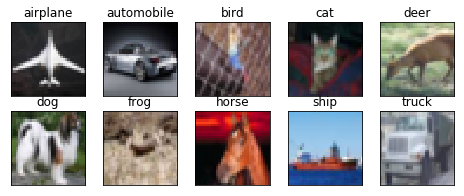

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
train_labels_integer = train_labels

test_labels_integer = test_labels

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels_integer[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
import numpy as np
from keras.callbacks import Callback

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img
      
    return eraser
  
  
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 3:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        #print(self.iteration, loss, lr)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])



By looking at several images, it appears that the receptive field is almost same as input image size.

Hence adding number of layers so that we reach the receptive field

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.layers import GlobalAveragePooling2D

from keras import optimizers

from keras import regularizers

In [0]:
# Define the model

def conv_block(model):
  
  model.add(Convolution2D(64, 3, 3,  border_mode='same')) 
  model.add(Activation('relu'))
  
  model.add(Convolution2D(128, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  model.add(Dropout(0.2))
  
  model.add(Convolution2D(256, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  model.add(Dropout(0.4))
  model.add(Convolution2D(512, 3, 3, border_mode='same'))
  model.add(Activation('relu'))
  
  return model

def transition_block(model):
  

  model.add(Convolution2D(32, 1, 1, border_mode='same'))

  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Convolution2D(32, 1, 1))


model.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


model.summary()

W0726 17:30:50.065890 140442622748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
W0726 17:30:50.122654 140442622748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 17:30:50.125813 140442622748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 17:30:50.229085 140442622748544 deprecation_wrapper.py:1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

W0726 17:30:55.301401 140442622748544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., callbacks=[<__main__..., verbose=0, steps_per_epoch=390)`
W0726 17:31:03.523815 140442622748544 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model took 42.52 seconds to train


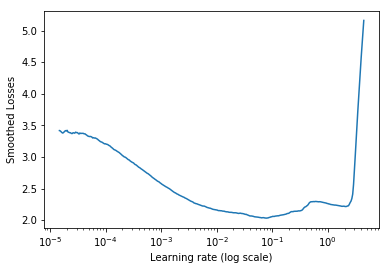

In [0]:
# Compile the model

sgd = optimizers.SGD(lr=0.01,  momentum=0.9)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                            preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                            )


datagen.fit(train_features)



iterator = datagen.flow(train_features, train_labels, batch_size = train_features.shape[0])

X_train_da, y_train_da = iterator.next()

iterator = datagen.flow(test_features, test_labels, batch_size = test_features.shape[0])

X_test_da, y_test_da = iterator.next()

# train the model
start = time.time()
# Train the model

bs = 128

lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_features.shape[0]/bs))

model_info = model.fit_generator(datagen.flow(X_train_da, y_train_da, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], 
                                 callbacks=[lr_finder] ,verbose=0)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

lr_finder.plot_smoothed_loss()

In [0]:
K.set_value(model.optimizer.lr, 0.005)

K.get_value(model.optimizer.lr)

0.005

0.005
Epoch 1/5
  2/390 [..............................] - ETA: 35s - loss: 14.9692 - acc: 0.0859

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=5)`
  app.launch_new_instance()


390/390 [==============================] - 33s 85ms/step - loss: 14.7552 - acc: 0.1000 - val_loss: 14.7546 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to assignment_11exp1_eva.hdf5
Epoch 2/5
390/390 [==============================] - 33s 86ms/step - loss: 14.7537 - acc: 0.1000 - val_loss: 14.7527 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/5
390/390 [==============================] - 32s 82ms/step - loss: 14.7518 - acc: 0.1000 - val_loss: 14.7508 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/5
390/390 [==============================] - 32s 82ms/step - loss: 14.7499 - acc: 0.1000 - val_loss: 14.7489 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.10000
Epoch 5/5
390/390 [==============================] - 32s 82ms/step - loss: 14.7477 - acc: 0.1000 - val_loss: 14.7470 - val_acc: 0.1000

Epoch 00005: val_acc did not improve from 0.10000
Model took 164.18 seconds to train


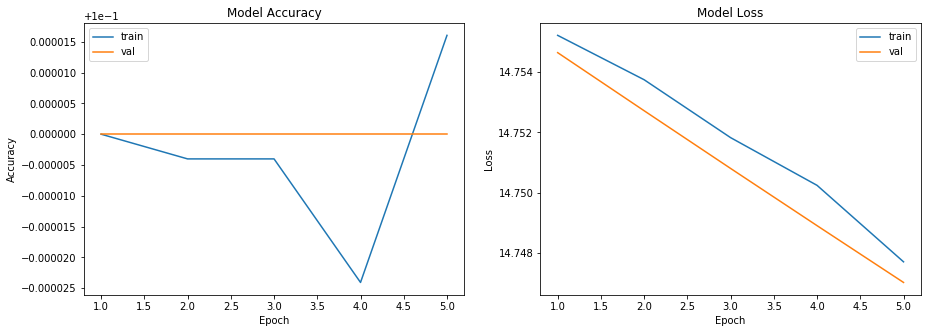

Accuracy on test data is: 10.00


In [0]:
filepath = "assignment_11exp1_eva.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

sgd = optimizers.SGD(lr=0.009,  momentum=0.6)

print(K.get_value(model.optimizer.lr))

#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


# train the model
start = time.time()

model_info = model.fit_generator(datagen.flow(X_train_da, y_train_da, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 5, 
                                 validation_data = (X_test_da, y_test_da), callbacks=[checkpoint] ,verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Epoch 1/95
  2/390 [..............................] - ETA: 29s - loss: 14.6665 - acc: 0.1055

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=95)`
  


390/390 [==============================] - 33s 84ms/step - loss: 14.7543 - acc: 0.1000 - val_loss: 14.7527 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to assignment_11exp1_eva.hdf5
Epoch 2/95
390/390 [==============================] - 32s 82ms/step - loss: 14.7508 - acc: 0.1001 - val_loss: 14.7508 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/95
390/390 [==============================] - 32s 82ms/step - loss: 14.7486 - acc: 0.1001 - val_loss: 14.7489 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/95
390/390 [==============================] - 32s 82ms/step - loss: 14.7516 - acc: 0.0998 - val_loss: 14.7470 - val_acc: 0.1000

Epoch 00004: val_acc did not improve from 0.10000
Epoch 5/95
390/390 [==============================] - 32s 82ms/step - loss: 14.7463 - acc: 0.1000 - val_loss: 14.7451 - val_acc: 0.1000

Epoch 00005: val_acc did not improve from 0.10000
Epoch 6/95
390/390 [===========

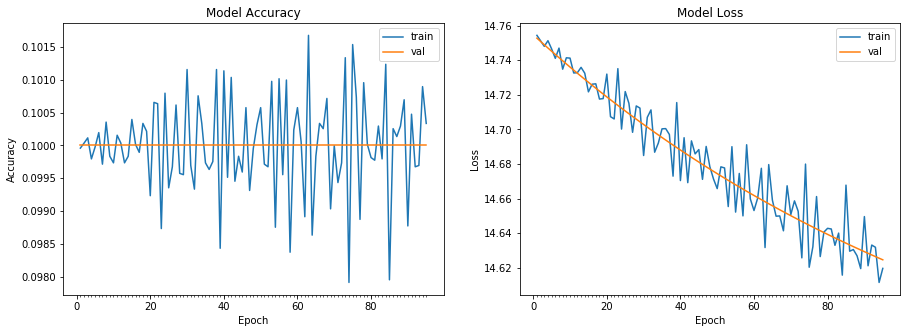

Accuracy on test data is: 10.00


In [14]:
# train the model
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
start = time.time()

model_info = model.fit_generator(datagen.flow(X_train_da, y_train_da, batch_size = bs),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 95, 
                                 validation_data = (X_test_da, y_test_da), callbacks=[checkpoint] ,verbose=1)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)

model.load_weights(filepath)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#image_in = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")

#cv2_imshow(image_in)

from google.colab.patches import cv2_imshow

from matplotlib import gridspec

from keras.preprocessing.image import img_to_array

import cv2

def get_gradcam(image_in, layer_name = "res5c_branch2c", num_kernels = 2048):
  

  #image_in = cv2.resize(image_in, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  x = img_to_array(image_in)

  x = x.reshape((1, image_in.shape[0], image_in.shape[1], image_in.shape[2]))

  #x = preprocess_input(x)

  preds = model.predict(x)

  class_idx = np.argmax(preds[0])

  #print(class_idx)

  class_output = model.output[:, class_idx]

  #print(imagenet_classes[class_idx])

  last_conv_layer = model.get_layer(layer_name)

  grads = K.gradients(class_output, last_conv_layer.output)[0]

  #print(grads.shape)

  pooled_grads = K.mean(grads, axis=(0, 1, 2))

  #print(pooled_grads.shape)

  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(num_kernels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)

  #print(conv_layer_output_value.shape)

  #print(heatmap.shape)

  heatmap = np.maximum(heatmap, 0)

  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (image_in.shape[1], image_in.shape[0]))

  heatmap = np.uint8(255 * heatmap)

  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(cv2.resize(image_in, dsize=(32, 32), interpolation=cv2.INTER_CUBIC), 0.5, heatmap, 0.5, 0, dtype = cv2.CV_32F)

  #cv2_imshow(image_in)

  #cv2_imshow(heatmap)

  #cv2_imshow(superimposed_img)
  
  return superimposed_img



def get_wrongly_classified_indices(predictions, y_vals):
  
  """
  Takes predicted and actual values
  Returns a tuple of misclassified image indexes and their corresponding predicted and actual values
  
  NOTE: Make sure your predictions are in the same order of actuals, using shuffle=False while predicting would be important
  
  Params:
  predictions: probability values of predictions
  y_vals: actual values of data
  """
  
  predicted_y = np.argmax(predictions, axis=1)
  
  actual_y = np.argmax(y_vals, axis = 1)
  
  wrong_indices = np.nonzero(~(actual_y == predicted_y))
  
  return (wrong_indices[0], predicted_y[wrong_indices[0]], actual_y[wrong_indices[0]])
  
  
def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig = plt.figure(figsize=(15,20))
    
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, wspace=0.4, hspace=0, top = 0.5, bottom  = 0)
    
    for ind,title in enumerate(figures):
        
        nested_gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[ind], wspace=0) # 1 row, 2 columns for each cluster
        
        ax = plt.Subplot(fig, nested_gs[0])
        
        
        ax.imshow(figures[title]["image"])
        
        fig.add_subplot(ax)
        
        ax.set_title(title)
        
        ax = plt.Subplot(fig, nested_gs[1])        
        
        ax.imshow(figures[title]["grad_cam"])
        
        fig.add_subplot(ax)
        
        
    plt.subplots_adjust(hspace = 0)
    plt.show()    
    


In [0]:
predictions = model.predict(test_features)
    
misclassified_image_idx = get_wrongly_classified_indices(predictions, test_labels)

print(misclassified_image_idx)

number_of_im = len(misclassified_image_idx[0])

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

if (number_of_im) > 25:
  number_of_im = 25

figures = {}

for i in range(number_of_im):
  
  title = str(i+1)+'.\tPredicted: '.expandtabs()+class_names[misclassified_image_idx[1][i]] + '\n\tActual: '.expandtabs() + class_names[misclassified_image_idx[2][i]]
  
  img_idx = misclassified_image_idx[0][i]
  
  image = test_features[img_idx].reshape(32,32,3)
  
  grad_cam = get_gradcam(image, layer_name = "last_conv", num_kernels = 256)
  
  figures[title] = {}
  
  figures[title]["image"] = image
  
  figures[title]["grad_cam"] = grad_cam
  
  #figures[title]["title"] = title
  

In [0]:
#import warnings
#warnings.filterwarnings("ignore")

plot_figures(figures, 5, 5)

In [0]:
import random

random_images_tolook = [random.randint(0,100) for x in range(15)]

actual_y = np.argmax(y_test_da, axis=1)

fig, axeslist = plt.subplots(ncols = 3, nrows = len(random_images_tolook)//3 , figsize=(15,8))

for ind in range(len(random_images_tolook)):
  
  axeslist.ravel()[ind].imshow(X_test_da[random_images_tolook[ind]])
  
  axeslist.ravel()[ind].set_title(class_names[actual_y[random_images_tolook[ind]]])
  
plt.subplots_adjust(hspace = 0.5)